# HPPC Parameter Extraction (Full)

The logic in this notebook is almost identical to that of `extract_hppc_partial.py`. 



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_tools.query import DBClient 
from data_tools.collections import TimeSeries
import datetime

from dotenv import load_dotenv

load_dotenv()

Could not find a POSTGRESQL_USERNAME in .env!
Could not find a POSTGRESQL_PASSWORD in .env!
Could not find a POSTGRESQL_DATABASE in .env!
Could not find a POSTGRESQL_ADDRESS in .env!


True

In [2]:
# client = DBClient(influxdb_token="s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==", influxdb_org="8a0b66d77a331e96")
# 
# start = datetime.datetime.fromisoformat("2025-04-11T00:00:00Z")
# stop = datetime.datetime.fromisoformat("2025-04-14T00:00:00Z")
# 
# pack_voltage = client.query_time_series(start=start, stop=stop, field="TotalPackVoltage", bucket="CAN_log", granularity=0.1, units="V", car="Brightside")
# pack_current = client.query_time_series(start=start, stop=stop, field="PackCurrent", bucket="CAN_log", granularity=0.1, units="A", car="Brightside")
# 
# pack_voltage, pack_current = TimeSeries.align(pack_voltage, pack_current)
import dill

# with open('pack_current_aligned.dill', 'wb') as current_file:
with open('pack_current_aligned.dill', 'rb') as current_file:
    # dill.dump(pack_current_aligned, current_file)
    pack_current = dill.load(current_file)
# with open('pack_voltage_aligned.dill', 'wb') as voltage_file:
with open('pack_voltage_aligned.dill', 'rb') as voltage_file:
    # dill.dump(pack_voltage_aligned, voltage_file)
    pack_voltage = dill.load(voltage_file)

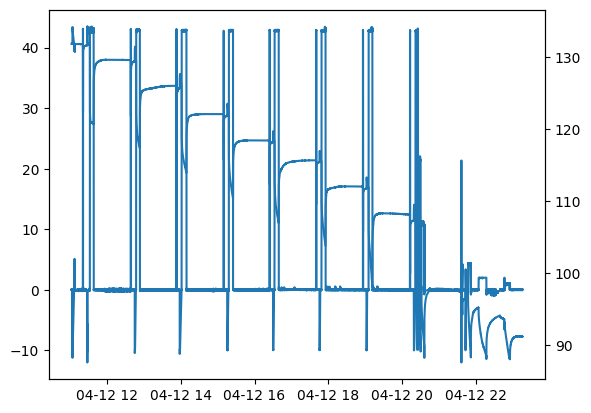

In [3]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.plot(pack_current.datetime_x_axis, pack_current)
ax2.plot(pack_voltage.datetime_x_axis, pack_voltage)
plt.show()

In [4]:
I_load, U_measured = TimeSeries.align(pack_current, pack_voltage)

# This notebook uses the opposite convention -> negative power = discharging
# InfluxDB and firmware uses the convention where -> positive power = discharging
power = U_measured * -I_load
power -= 2           # ~2 watts of power draw for LEDs, contactors, etc

N = len(U_measured)  # Number of data points

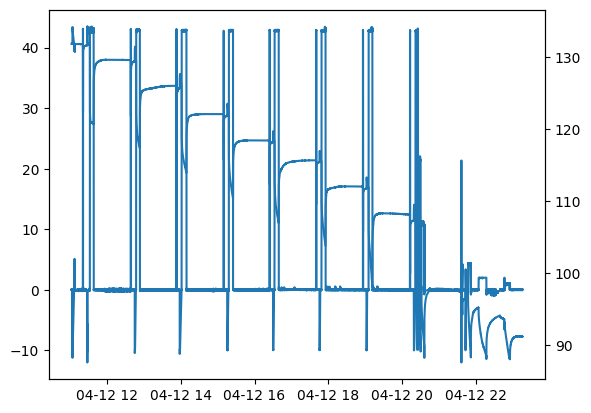

In [5]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.plot(I_load.datetime_x_axis, I_load)
ax2.plot(U_measured.datetime_x_axis, U_measured)
plt.show()

We need to identify the SOC that we performed each pulse at; since the battery was relaxed before the pulse begins, we can read it off from the voltage. For this, I'm stealing Jonah's SOC from voltage interpolation code.

I'm going to manually read off indices that are from right before a pulse, and index the SoC from interpolation at those indices.


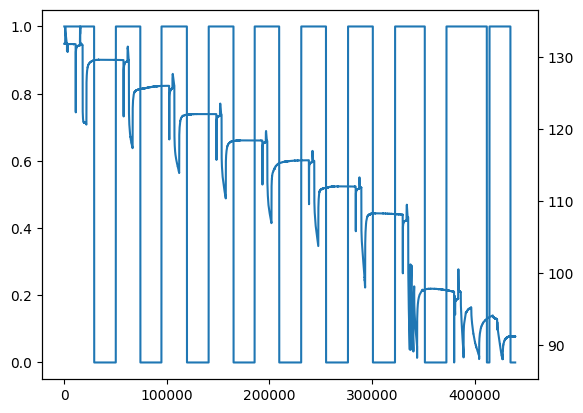

In [6]:
boundary_indices = 7500
nonzero_mask = (I_load > 1.0) | (I_load < -1.0)
window = np.ones(2 * boundary_indices + 1, dtype=int)
current_mask = np.convolve(nonzero_mask, window, mode='same') > 0

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.plot(pack_voltage)
ax.plot(current_mask, label="Mask")
plt.show()

We need a few more constants.

In [7]:
# From offline parameter extraction
R_0_data = [0.17953765302439662, 0.15580951404728172, 0.14176929930784543, 0.11043950958574644, 0.13930042505446938, 0.1552885289394773, 0.044070982259896085, 0.2208806896239539, 0.15116267852908616, 0.6553961767519164]
R_P_data = [0.04153180244191346, 0.10674683402208612, 0.061085424180509884, 0.0781407642082238, 0.05537901113775878, 0.09732054673529467, 0.07662520885708152, 0.09799857401036915, 0.42622740149661487, 0.2718418915736874]
C_P_data = [14824.398495212006, 1587.5971318119796, 341.1064063616048, 1243.182413110655, 619.5791066439332, 2252.7885790042164, 954.5884882581622, 515.7219779825028, 431.10892633451135, 195.14394897766627]
Uoc_data = [131.88002282453857, 129.4574321366064, 125.5750277614186, 121.99586066440303, 118.69893412178982, 115.71854177322408, 111.99025635444923, 108.29354777060836, 98.23397960300946, 95.24125831782388]
Q_total = 137541.31995522053
SOC_data = [1.0000113624123392, 0.8815263722745977, 0.7671918526292492, 0.6206071038045673, 0.4911613638651783, 0.3606311083423134, 0.23687514228021178, 0.12073345089992571, 0.01456057818183809, 0.0070648691224265425]

# Bounds derived from conventional battery ranges
initial_guess = (
    R_0_data +   # R_0_data (Ohmic Resistance)
    R_P_data +   # R_P_data (Polarization Resistance), 
    C_P_data +   # C_P_data (Capacitance)
    Uoc_data     # Uoc_data (Open Circuit Voltage)
)

In [8]:
# Function to plot objective function with initial guess
def plot_results(soc_array, voltage_array, power, U_measured, optimize):
    time = np.arange(len(power))

    plt.figure(figsize=(12, 6))

    # Plot SOC
    plt.subplot(2, 1, 1)
    plt.plot(time, soc_array, label="Predicted State of Charge (SOC)", color="blue")

    plt.xlabel("Time (s)")
    plt.ylabel("SOC (%)")
    if optimize:
        plt.title("Battery Simulation after Optimization: Predicted vs Real State of Charge Over Time")
    else:
        plt.title("Battery Simulation before Optimization: Predicted vs Real State of Charge Over Time")

    plt.grid(True)
    plt.legend()

    # Calculate min/max voltage values
    min_voltage = min(np.min(voltage_array), np.min(U_measured))
    max_voltage = max(np.max(voltage_array), np.max(U_measured))
    margin = (max_voltage - min_voltage) * 0.05  # 5% margin for visibility

    # Plot Voltage
    plt.subplot(2, 1, 2)
    plt.plot(time, voltage_array, label="Predicted Voltage", color="orange")
    plt.plot(time, U_measured, label="Real Voltage", color="red", linestyle="dashed")  # Real voltage added
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    if optimize:
        plt.title("Battery Simulation after Optimization: Predicted vs Real Voltage Over Time")
    else:
        plt.title("Battery Simulation before Optimization: Predicted vs Real Voltage Over Time")


    plt.ylim(min_voltage - margin, max_voltage + margin)  # Adjust Y-axis dynamically
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def mse(array_1, array_2):
    return np.mean(np.power(array_1 - array_2, 2)[current_mask])

In [10]:
from physics.models.battery import EquivalentCircuitBatteryModel, BatteryModelConfig


def run_battery_model(params, total_charge) -> tuple[np.ndarray, np.ndarray]:
    battery_config = BatteryModelConfig(
        R_0_data=params[:10],  # Optimized R_0_data
        R_P_data=params[10:20],        # Optimized R_P
        C_P_data=params[20:30],        # Optimized C_P
        Q_total=total_charge,
        Soc_data=SOC_data,     # Hardcoded SOC data
        Uoc_data=params[30:40],# Optimized Uoc_data
    )
    bm = EquivalentCircuitBatteryModel(battery_config, state_of_charge=0.99)
    
    # Run Battery Model
    soc_array, U_predicted = bm.update_array(current_array=-pack_current, tick=pack_current.granularity, use_compiled=True)

    return soc_array, U_predicted

/var/folders/26/b439y_h53ls_5yw6crm1x55r0000gn/T/ipykernel_13633/3016915264.py:16: DeprecationWarning: Please use TimeSeries.period instead of TimeSeries.granularity
  soc_array, U_predicted = bm.update_array(current_array=-pack_current, tick=pack_current.granularity, use_compiled=True)


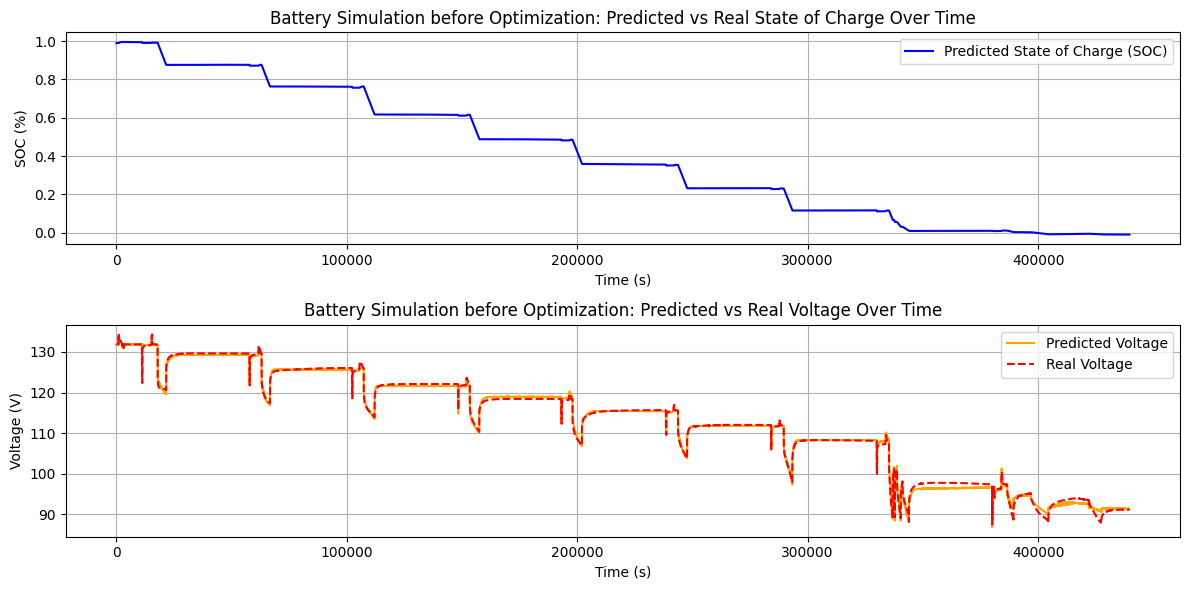

TimeSeries(0.3924951)

In [11]:
# Define the objective function
def objective_voltage(params, visualize=True, optimized=False):
    # Run Battery Model
    soc_array, U_predicted = run_battery_model(params, Q_total)

    # Compute Errors
    mse_voltage = mse(U_measured, U_predicted)

    # Visualize Results
    if visualize:
        plot_results(soc_array, U_predicted, pack_current, U_measured, optimized)

    return mse_voltage

objective_voltage(initial_guess)

In [17]:
soc_array, U_predicted = run_battery_model(initial_guess, Q_total)

/var/folders/26/b439y_h53ls_5yw6crm1x55r0000gn/T/ipykernel_9711/3016915264.py:16: DeprecationWarning: Please use TimeSeries.period instead of TimeSeries.granularity
  soc_array, U_predicted = bm.update_array(current_array=-pack_current, tick=pack_current.granularity, use_compiled=True)


In [21]:
U_predicted[-1]

np.float64(94.0649817466934)

In [21]:
from sklearn.preprocessing import MinMaxScaler
import warnings


# Original (non-normalized) bounds
lower_bounds = np.array(
    [0.0]*10 +          # R_0_data
    [0.0]*10 +          # R_P_data
    [0.0]*10 +          # C_P_data
    [85.0]*10           # U_oc_data
)
upper_bounds = np.array(
    [1.0]*10 +          # R_0_data
    [1.0]*10 +          # R_P_data
    [50000.0]*10 +      # C_P_data
    [135.0]*10          # U_oc_data
)
bounds = list(zip(lower_bounds, upper_bounds))


# Create a scaler to map [lower_bounds, upper_bounds] <-> [0, 1]
scaler = MinMaxScaler()
scaler.fit(np.vstack([lower_bounds, upper_bounds]))  # shape (2, n_features)


# --- Scaled objective function ---
def scaled_objective(scaled_params):
    real_params = scaler.inverse_transform([scaled_params])[0]
    return objective_voltage(real_params, visualize=False)


def make_callback(patience=100, min_delta=1e-6):
    best = {"val": np.inf, "iter": 0, "last_improved": 0}

    def callback(x, convergence):
        best["iter"] += 1
        real_params = scaler.inverse_transform([x])[0]
        loss = objective_voltage(real_params, visualize=False)

        if loss < best["val"] - min_delta:
            print(f"Iter {best['iter']:3d} | Loss: {loss:.6f}")
            best["val"] = loss
            best["last_improved"] = best["iter"]
            
        elif best["iter"] - best["last_improved"] > patience:
            print(f"Early Stopping: No improvement in {patience} iterations...")
            raise StopIteration

    return callback


# --- Define initial guess and scale it ---
initial_guess_scaled = scaler.transform([initial_guess])[0]


# --- Generate tight population around initial guess (±5% of range) ---
def make_initial_population(guess_scaled, num_individuals, noise_scale=0.001):
    population = [guess_scaled]
    for _ in range(num_individuals - 1):
        noise = noise_scale * (np.random.rand(len(guess_scaled)) - 0.5)
        candidate = np.clip(guess_scaled + noise, 0.0, 1.0)
        population.append(candidate)
    return np.array(population)

population_size = 50  # per DE default
num_params = len(initial_guess)
init_population = make_initial_population(initial_guess_scaled, population_size)

In [22]:
from scipy import optimize 

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    result = optimize.differential_evolution(
        scaled_objective,
        bounds=[(0.0, 1.0)] * len(lower_bounds),
        init=init_population,
        strategy="rand1bin",
        maxiter=300,
        popsize=population_size,
        tol=1e-4,
        mutation=(0.33, 0.75),
        recombination=0.8,
        callback=make_callback(),
        disp=True
    )

differential_evolution step 1: f(x)= 1.2782469261851037
Iter   1 | Loss: 1.278247
differential_evolution step 2: f(x)= 1.2730949483983534
Iter   2 | Loss: 1.273095
differential_evolution step 3: f(x)= 1.2700439494660742
Iter   3 | Loss: 1.270044
differential_evolution step 4: f(x)= 1.266599660412367
Iter   4 | Loss: 1.266600
differential_evolution step 5: f(x)= 1.2649947273061015
Iter   5 | Loss: 1.264995
differential_evolution step 6: f(x)= 1.2524366249374026
Iter   6 | Loss: 1.252437
differential_evolution step 7: f(x)= 1.2471855152618068
Iter   7 | Loss: 1.247186
differential_evolution step 8: f(x)= 1.2415006288376587
Iter   8 | Loss: 1.241501
differential_evolution step 9: f(x)= 1.235378035894546
Iter   9 | Loss: 1.235378
differential_evolution step 10: f(x)= 1.222663464436571
Iter  10 | Loss: 1.222663
differential_evolution step 11: f(x)= 1.222663464436571
differential_evolution step 12: f(x)= 1.2155320387936226
Iter  12 | Loss: 1.215532
differential_evolution step 13: f(x)= 1.186

/var/folders/26/b439y_h53ls_5yw6crm1x55r0000gn/T/ipykernel_56044/461033253.py:18: DeprecationWarning: Please use TimeSeries.period instead of TimeSeries.granularity
  soc_array, U_predicted = bm.update_array_current(-pack_current, pack_current.granularity, rust=True)


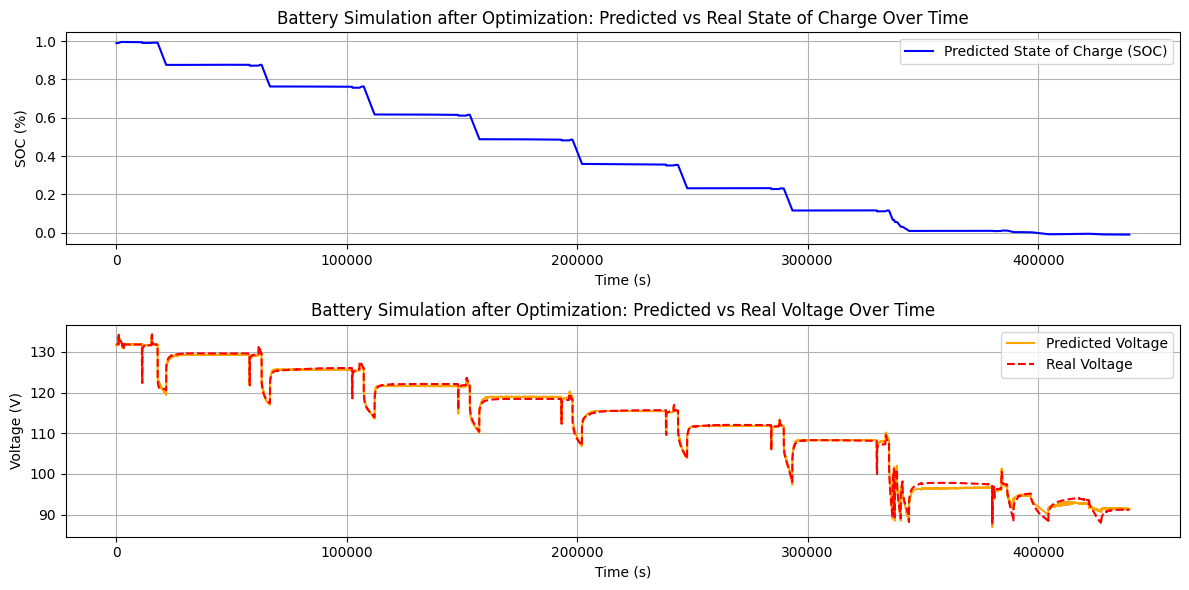

In [23]:
# result_polished = optimize.minimize(scaled_objective, result.x, method='Powell', bounds=[(0.0, 1.0)] * len(lower_bounds))

final_params = scaler.inverse_transform([result.x])[0]

# Compute MSE for both SOC and Voltage
mse_voltage = objective_voltage(final_params, visualize=True, optimized=True)

In [24]:
formatted_params = f"""
🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): {", ".join([f"{x:.6f}" for x in final_params[:10]])}
- R_P (Polarization Resistance): {", ".join([f"{x:.6f}" for x in final_params[10:20]])}
- C_P (Capacitance): {", ".join([f"{x:.6f}" for x in final_params[20:30]])}
- Uoc_data (Open Circuit Voltage): {", ".join([f"{x:.6f}" for x in final_params[30:40]])}
🔹 **Final MSE Voltage:** {mse_voltage:.12e}
"""

print(formatted_params)


🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): 0.179538, 0.155810, 0.141769, 0.110440, 0.139300, 0.155289, 0.044071, 0.220881, 0.151163, 0.655396
- R_P (Polarization Resistance): 0.041532, 0.106747, 0.061085, 0.078141, 0.055379, 0.097321, 0.076625, 0.097999, 0.426227, 0.271842
- C_P (Capacitance): 14824.398495, 1587.597132, 341.106406, 1243.182413, 619.579107, 2252.788579, 954.588488, 515.721978, 431.108926, 195.143949
- Uoc_data (Open Circuit Voltage): 131.880023, 129.457432, 125.575028, 121.995861, 118.698934, 115.718542, 111.990256, 108.293548, 98.233980, 95.241258
🔹 **Final MSE Voltage:** 3.925740049273e-01



In [31]:
start_fsgp = datetime.datetime.fromisoformat("2024-07-16T14:00:00Z")
stop_fsgp = datetime.datetime.fromisoformat("2024-07-17T01:00:00Z")

pack_voltage_fsgp = client.query_time_series(start=start_fsgp, stop=stop_fsgp, field="TotalPackVoltage", bucket="CAN_log", granularity=0.1, units="V", car="Brightside")
pack_current_fsgp = client.query_time_series(start=start_fsgp, stop=stop_fsgp, field="PackCurrent", bucket="CAN_log", granularity=0.1, units="A", car="Brightside")

pack_voltage_fsgp, pack_current_fsgp =TimeSeries.align(pack_voltage_fsgp, pack_current_fsgp)

In [32]:
raw_params = f"""
R_0_data = {[float(x) for x in final_params[:10]]}
R_P_data = {[float(x) for x in final_params[10:20]]}
C_P_data = {[float(x) for x in final_params[20:30]]}
Uoc_data = {[float(x) for x in final_params[30:40]]}
Q_total = {Q_estimated}
SOC_data = {[float(x) for x in SOC_data]}
"""

print(raw_params)


R_0_data = [0.17953765302439662, 0.15580951404728172, 0.14176929930784543, 0.11043950958574644, 0.13930042505446938, 0.1552885289394773, 0.044070982259896085, 0.2208806896239539, 0.15116267852908616, 0.6553961767519164]
R_P_data = [0.04153180244191346, 0.10674683402208612, 0.061085424180509884, 0.0781407642082238, 0.05537901113775878, 0.09732054673529467, 0.07662520885708152, 0.09799857401036915, 0.42622740149661487, 0.2718418915736874]
C_P_data = [14824.398495212006, 1587.5971318119796, 341.1064063616048, 1243.182413110655, 619.5791066439332, 2252.7885790042164, 954.5884882581622, 515.7219779825028, 431.10892633451135, 195.14394897766627]
Uoc_data = [131.88002282453857, 129.4574321366064, 125.5750277614186, 121.99586066440303, 118.69893412178982, 115.71854177322408, 111.99025635444923, 108.29354777060836, 98.23397960300946, 95.24125831782388]
Q_total = 137541.31995522053
SOC_data = [1.0000113624123392, 0.8815263722745977, 0.7671918526292492, 0.6206071038045673, 0.4911613638651783, 0.